In [1]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage,dendrogram

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np 
import pandas as pd 
import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows",50)
pd.set_option("display.float_format", lambda x:"%.2f" % x)
pd.set_option("display.width",1000)

df_= pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
df=df_.copy()
df.columns= df.columns.str.replace(" ","_").str.upper()
df.head()

,INVOICE,STOCKCODE,DESCRIPTION,QUANTITY,INVOICEDATE,PRICE,CUSTOMER_ID,COUNTRY
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [3]:
def check_data(df,head=5):
    print("-------------SHAPE---------------")
    print(df.shape)
    print("-------------INFO----------------")
    print(df.info())
    print("-----------DESCRIBE--------------")
    print(df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print("----------NA VALUES--------------")
    print(df.isnull().sum())
    print("--------FIRST {} ROWS------------".format(head))
    print(df.head(head))

In [4]:
def select_country(df,country):
    country_df = df.loc[df("Country") == country]
    return country_df

In [5]:
def outlier_thresholds(df,col_name,q1=0.05,q3=0.95):
    quartile1= df[col_name].quantile(q1)
    quartile3= df[col_name].quantile(q3)
    inquantile_range= quartile3 - quartile1
    up_limit=quartile3 + 1.5 * inquantile_range
    low_limit=quartile1 - 1.5 * inquantile_range
    return low_limit, up_limit

In [6]:
def check_outlier(df, col_name, q1=0.05,q3=0.95):
    low_limit, up_limit = outlier_thresholds(df,col_name,q1,q3)
    if (df[ (df[col_name] > up_limit) | (df[col_name] < low_limit)]).any(axis=None):
        return True
    else:
        return False

In [7]:
def replace_with_thresholds(df,col_name):
    low_limit, up_limit = outlier_thresholds(df,col_name)
    df.loc[(df[col_name] < low_limit), col_name]= low_limit
    df.loc[(df[col_name] > up_limit ), col_name]= up_limit

In [8]:
check_data(df)

-------------SHAPE---------------
(1067371, 8)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   INVOICE      1067371 non-null  object 
 1   STOCKCODE    1067371 non-null  object 
 2   DESCRIPTION  1062989 non-null  object 
 3   QUANTITY     1067371 non-null  int64  
 4   INVOICEDATE  1067371 non-null  object 
 5   PRICE        1067371 non-null  float64
 6   CUSTOMER_ID  824364 non-null   float64
 7   COUNTRY      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None
-----------DESCRIBE--------------
        QUANTITY      PRICE  CUSTOMER_ID
count 1067371.00 1067371.00    824364.00
mean        9.94       4.65     15324.64
std       172.71     123.55      1697.46
min    -80995.00  -53594.36     12346.00
1%         -3.00       0.21     12422.00
10%         1.00   

In [9]:
#INVOICE kodunda bulunan ve anlamını bilmediğimiz C Harf içeren satışları ayrıştırıyorum
df = df[~df["INVOICE"].str.contains("C", na=False)]

#QUANTITY'de bulunan eksi değer içeren değerleri ayrıştırıyoruz
df = df[df["QUANTITY"] > 0]

#STOCKCODE da harf içeren değerleri ayrıştıyoruz
df = df[~df['STOCKCODE'].str.contains(r'[a-zA-Z]')]

#Boş değerleri siliyoruz
df.dropna(inplace=True)

#İndexleri yeniden sıralıyoruz
df = df.reset_index(drop=True)


In [10]:
check_data(df)

-------------SHAPE---------------
(714048, 8)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714048 entries, 0 to 714047
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   INVOICE      714048 non-null  object 
 1   STOCKCODE    714048 non-null  object 
 2   DESCRIPTION  714048 non-null  object 
 3   QUANTITY     714048 non-null  int64  
 4   INVOICEDATE  714048 non-null  object 
 5   PRICE        714048 non-null  float64
 6   CUSTOMER_ID  714048 non-null  float64
 7   COUNTRY      714048 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 43.6+ MB
None
-----------DESCRIBE--------------
       QUANTITY     PRICE  CUSTOMER_ID
count 714048.00 714048.00    714048.00
mean      13.41      2.93     15327.46
std      151.65      4.39      1695.76
min        1.00      0.00     12346.00
1%         1.00      0.29     12421.00
10%        1.00      0.55     12976.00
25%  

In [11]:
df["TOTAL_PRICE"]= df["QUANTITY"] * df["PRICE"]
check_data(df)

-------------SHAPE---------------
(714048, 9)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714048 entries, 0 to 714047
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   INVOICE      714048 non-null  object 
 1   STOCKCODE    714048 non-null  object 
 2   DESCRIPTION  714048 non-null  object 
 3   QUANTITY     714048 non-null  int64  
 4   INVOICEDATE  714048 non-null  object 
 5   PRICE        714048 non-null  float64
 6   CUSTOMER_ID  714048 non-null  float64
 7   COUNTRY      714048 non-null  object 
 8   TOTAL_PRICE  714048 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 49.0+ MB
None
-----------DESCRIBE--------------
       QUANTITY     PRICE  CUSTOMER_ID  TOTAL_PRICE
count 714048.00 714048.00    714048.00    714048.00
mean      13.41      2.93     15327.46        21.51
std      151.65      4.39      1695.76       234.31
min        1.00      0.00  

In [12]:
# InvoiceDate sütununu datetime verisine dönüştürme
df["INVOICEDATE"] = pd.to_datetime(df["INVOICEDATE"])

max_invoice_date = df["INVOICEDATE"].max()
today_date = (max_invoice_date + dt.timedelta(days=2))

In [13]:
#rfm tablosu oluşturuyorum
rfm = df.groupby("CUSTOMER_ID").agg({"INVOICEDATE": lambda date:( today_date - date.max()).days,
                                     "INVOICE": "nunique",
                                     "TOTAL_PRICE": "sum"
                                    })
rfm.columns=["RECENCY","FREQUENCY","MONETARY"]
rfm = rfm[(rfm["MONETARY"] >0 ) & (rfm["FREQUENCY"]>0)]
check_data(rfm)

-------------SHAPE---------------
(5817, 3)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5817 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RECENCY    5817 non-null   int64  
 1   FREQUENCY  5817 non-null   int64  
 2   MONETARY   5817 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 181.8 KB
None
-----------DESCRIBE--------------
       RECENCY  FREQUENCY  MONETARY
count  5817.00    5817.00   5817.00
mean    200.80       6.20   2640.08
std     208.21      12.51  13161.87
min       2.00       1.00      2.95
1%        2.00       1.00     36.41
10%      10.00       1.00    139.97
25%      26.00       1.00    307.78
50%      96.00       3.00    791.53
75%     380.00       7.00   2058.40
90%     532.00      13.00   4779.53
95%     623.00      20.00   8441.65
99%     727.00      45.84  26752.55
max     739.00     372.00 553408.56
----------

In [14]:
for col in rfm.columns:
    print(col, check_outlier(rfm, col))

RECENCY False
FREQUENCY True
MONETARY True


In [15]:
for col in rfm.columns:
    replace_with_thresholds(rfm, col)
check_data(rfm)

-------------SHAPE---------------
(5817, 3)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5817 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RECENCY    5817 non-null   int64  
 1   FREQUENCY  5817 non-null   float64
 2   MONETARY   5817 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 181.8 KB
None
-----------DESCRIBE--------------
       RECENCY  FREQUENCY  MONETARY
count  5817.00    5817.00   5817.00
mean    200.80       5.75   2003.68
std     208.21       7.68   3443.17
min       2.00       1.00      2.95
1%        2.00       1.00     36.41
10%      10.00       1.00    139.97
25%      26.00       1.00    307.78
50%      96.00       3.00    791.53
75%     380.00       7.00   2058.40
90%     532.00      13.00   4779.53
95%     623.00      20.00   8441.65
99%     727.00      45.84  20959.88
max     739.00      48.50  20959.88
----------

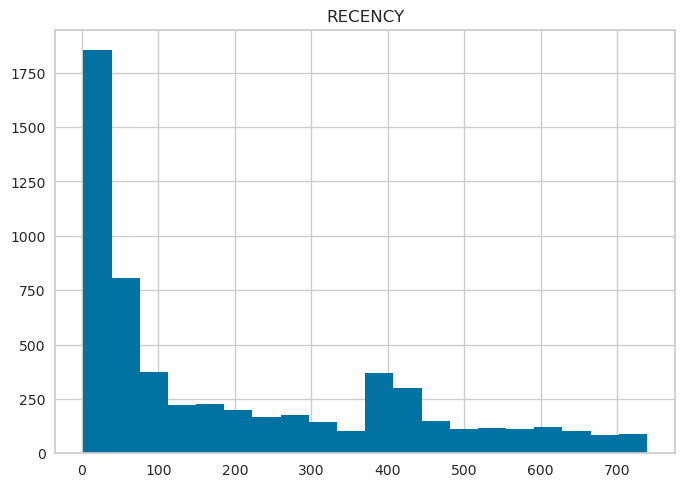

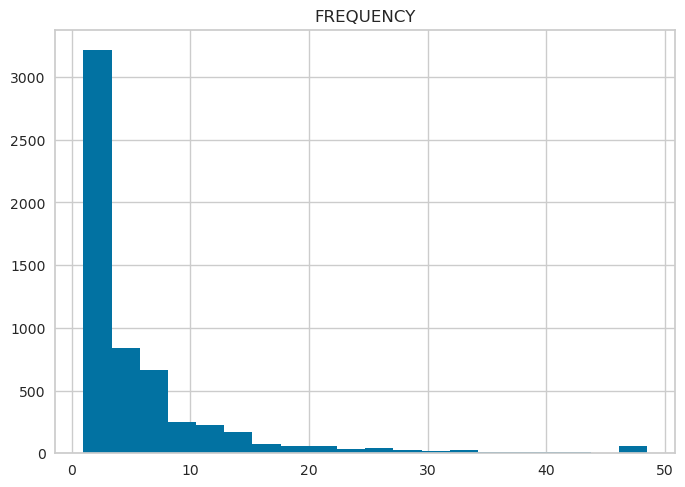

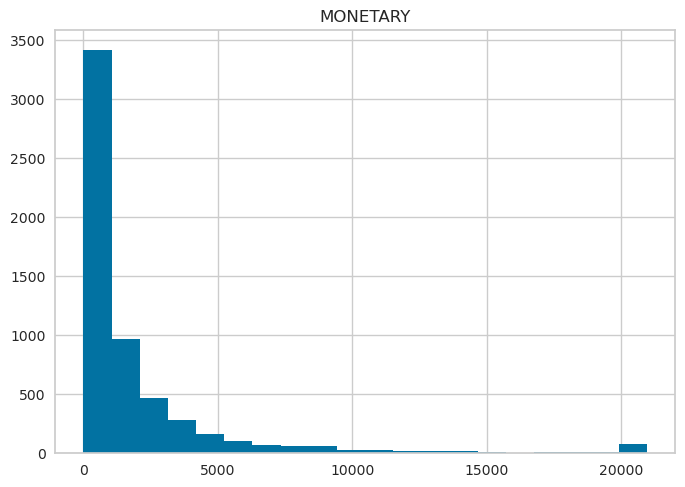

In [16]:
for col in rfm.columns:
    rfm[col].hist(bins=20)
    plt.title(col)
    plt.show()

In [17]:
#LOG işlemi ile değerleri normale yaklaştırıyorum
for col in ["RECENCY","FREQUENCY"]:
    rfm[f"LOG_{col}"]= np.log1p(rfm[col])
check_data(rfm)

-------------SHAPE---------------
(5817, 5)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5817 entries, 12346.0 to 18287.0
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RECENCY        5817 non-null   int64  
 1   FREQUENCY      5817 non-null   float64
 2   MONETARY       5817 non-null   float64
 3   LOG_RECENCY    5817 non-null   float64
 4   LOG_FREQUENCY  5817 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 272.7 KB
None
-----------DESCRIBE--------------
       RECENCY  FREQUENCY  MONETARY  LOG_RECENCY  LOG_FREQUENCY
count  5817.00    5817.00   5817.00      5817.00        5817.00
mean    200.80       5.75   2003.68         4.48           1.54
std     208.21       7.68   3443.17         1.50           0.79
min       2.00       1.00      2.95         1.10           0.69
1%        2.00       1.00     36.41         1.10           0.69
10%      10.00       1

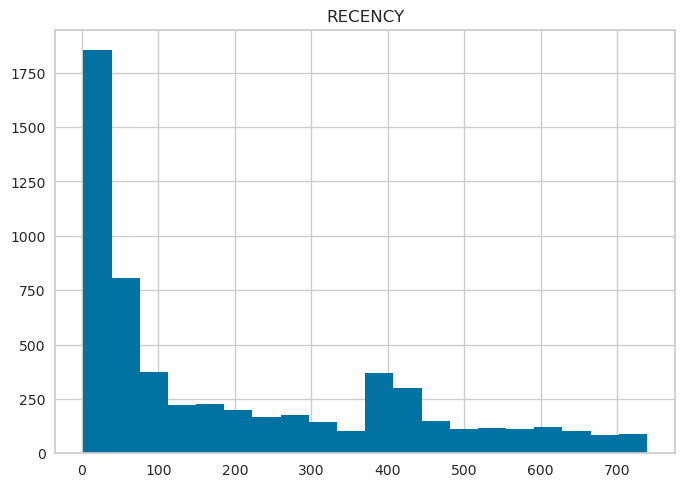

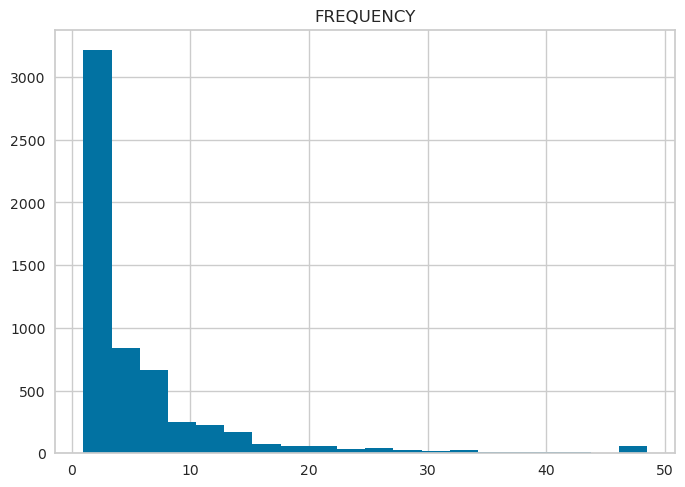

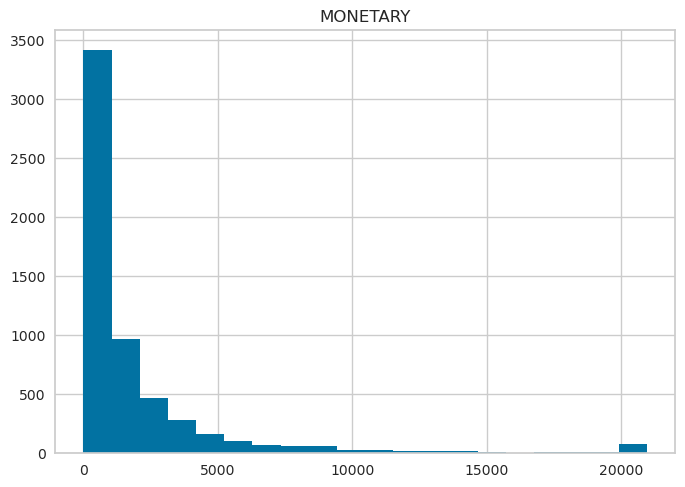

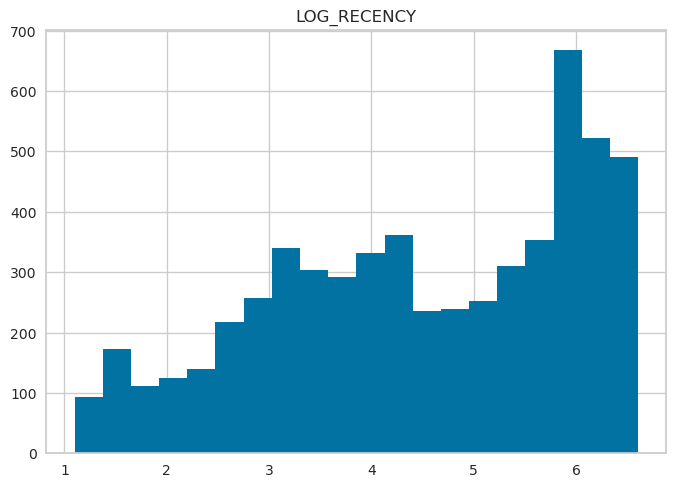

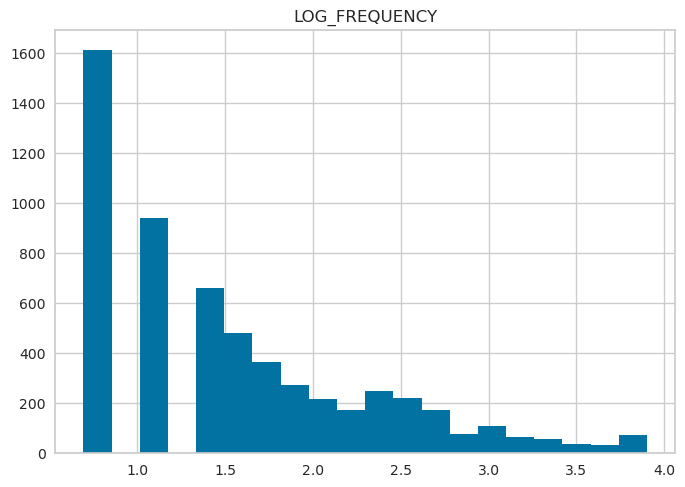

In [18]:
for col in rfm.columns:
    rfm[col].hist(bins=20)
    plt.title(col)
    plt.show()

In [19]:
#SCALER işlemi
sc= StandardScaler()

sc.fit(rfm[["LOG_RECENCY","LOG_FREQUENCY"]])
scaled_rfm = sc.transform(rfm[["LOG_RECENCY","LOG_FREQUENCY"]])

scaled_df = pd.DataFrame(index=rfm.index, columns=["LOG_RECENCY","LOG_FREQUENCY"], data=scaled_rfm)
check_data(scaled_df)

-------------SHAPE---------------
(5817, 2)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5817 entries, 12346.0 to 18287.0
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOG_RECENCY    5817 non-null   float64
 1   LOG_FREQUENCY  5817 non-null   float64
dtypes: float64(2)
memory usage: 136.3 KB
None
-----------DESCRIBE--------------
       LOG_RECENCY  LOG_FREQUENCY
count      5817.00        5817.00
mean         -0.00          -0.00
std           1.00           1.00
min          -2.25          -1.07
1%           -2.25          -1.07
10%          -1.39          -1.07
25%          -0.79          -1.07
50%           0.06          -0.19
75%           0.97           0.69
90%           1.19           1.40
95%           1.30           1.91
99%           1.40           2.93
max           1.41           3.00
----------NA VALUES--------------
LOG_RECENCY      0
LOG_FREQUENCY    0


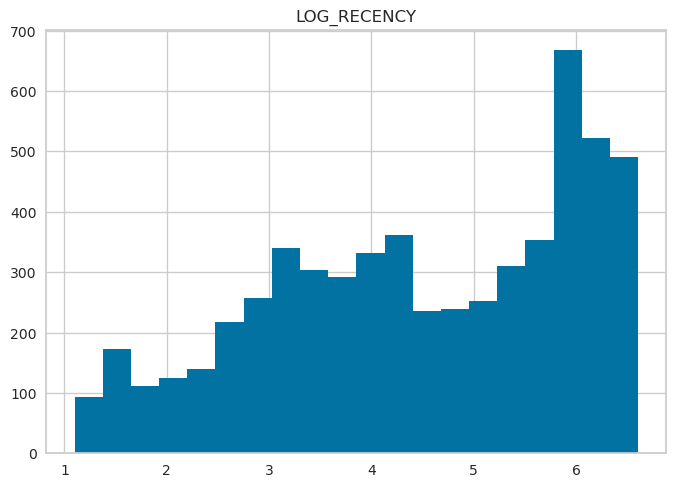

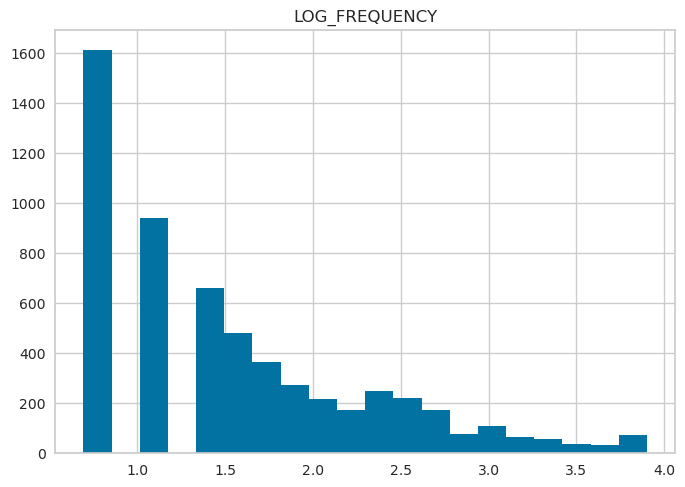

In [20]:
for col in scaled_df.columns:
    rfm[col].hist(bins=20)
    plt.title(col)
    plt.show()

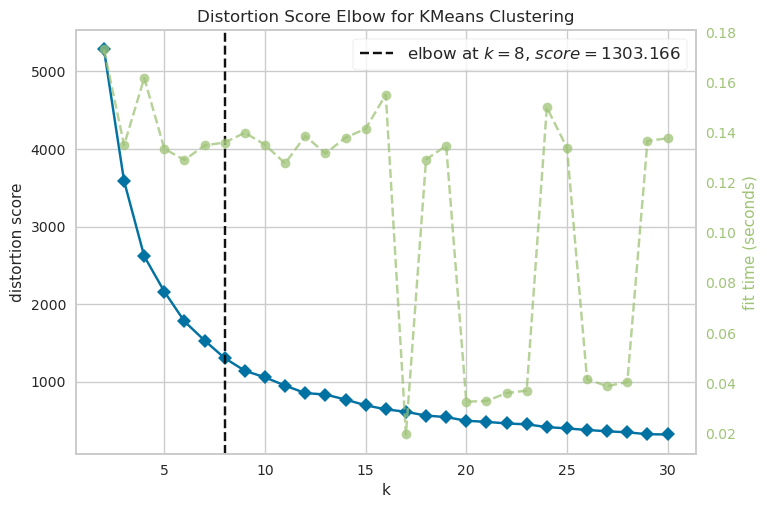

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
#KMEANS Optimal Numbers of Cluster
kmeans= KMeans(n_init="auto")
elbow = KElbowVisualizer(kmeans, k=30)
elbow.fit(scaled_df)
elbow.show()

In [22]:
k_ = elbow.elbow_value_
kmeans= KMeans(n_init="auto", n_clusters=k_, random_state=99).fit(scaled_df)

In [23]:
segments=kmeans.labels_
rfm["KMEANS_SEGMENTS"] = segments+1
check_data(rfm)

-------------SHAPE---------------
(5817, 6)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5817 entries, 12346.0 to 18287.0
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RECENCY          5817 non-null   int64  
 1   FREQUENCY        5817 non-null   float64
 2   MONETARY         5817 non-null   float64
 3   LOG_RECENCY      5817 non-null   float64
 4   LOG_FREQUENCY    5817 non-null   float64
 5   KMEANS_SEGMENTS  5817 non-null   int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 295.4 KB
None
-----------DESCRIBE--------------
       RECENCY  FREQUENCY  MONETARY  LOG_RECENCY  LOG_FREQUENCY  KMEANS_SEGMENTS
count  5817.00    5817.00   5817.00      5817.00        5817.00          5817.00
mean    200.80       5.75   2003.68         4.48           1.54             4.45
std     208.21       7.68   3443.17         1.50           0.79             2.06
min       2.

In [24]:
rfm.groupby("KMEANS_SEGMENTS").agg({"RECENCY": ["median","mean","count"],
                                    "FREQUENCY":["median","mean","count"],
                                    "MONETARY": ["median","mean","count"]
                                   })

RECENCY              FREQUENCY             MONETARY               
                 median   mean count    median  mean count   median     mean count
KMEANS_SEGMENTS                                                                   
1                 13.00  14.00   475      2.00  2.52   475   607.60   834.66   475
2                  6.00   9.28   342     26.00 29.30   342  9007.28 10936.90   342
3                425.50 445.00  1674      1.00  1.31  1674   251.28   382.52  1674
4                 57.00  60.86   739      4.00  4.61   739  1221.67  1591.41   739
5                 12.00  12.11   548      8.00  8.62   548  2354.18  2946.32   548
6                313.00 320.74   838      4.00  4.46   838   970.75  1350.23   838
7                 65.00  73.88   641      1.00  1.41   641   352.88   509.94   641
8                 57.50  81.34   560     12.00 12.99   560  3602.47  4694.95   560

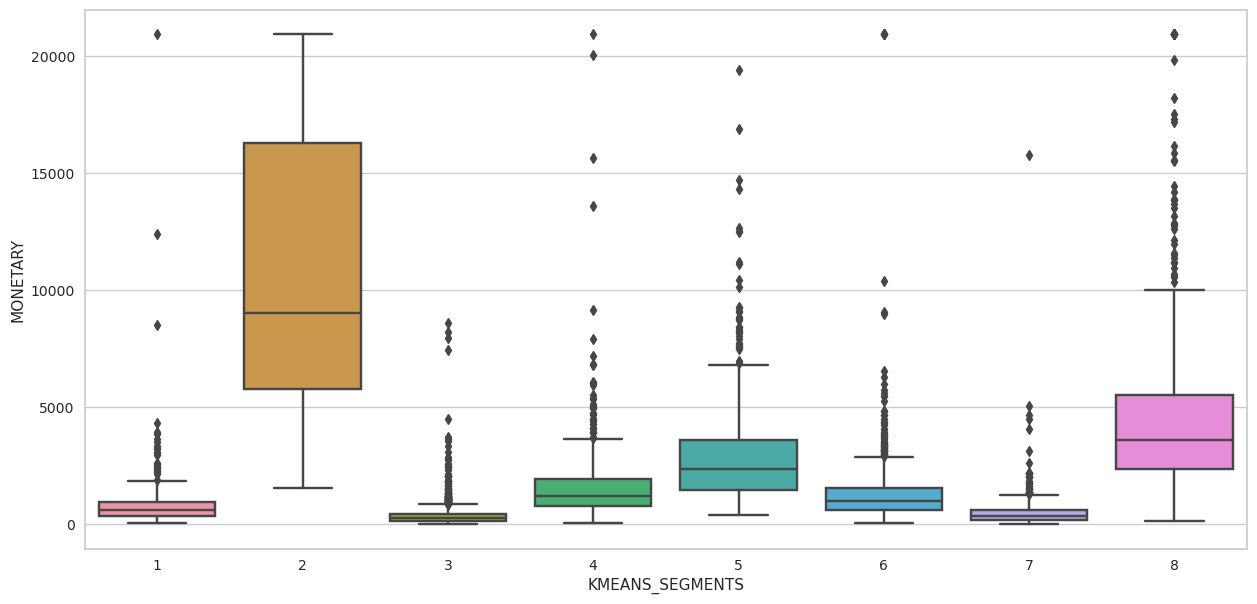

In [25]:
plt.figure(figsize=(15,7))
sns.boxplot(x="KMEANS_SEGMENTS", y="MONETARY", data=rfm)
plt.show()

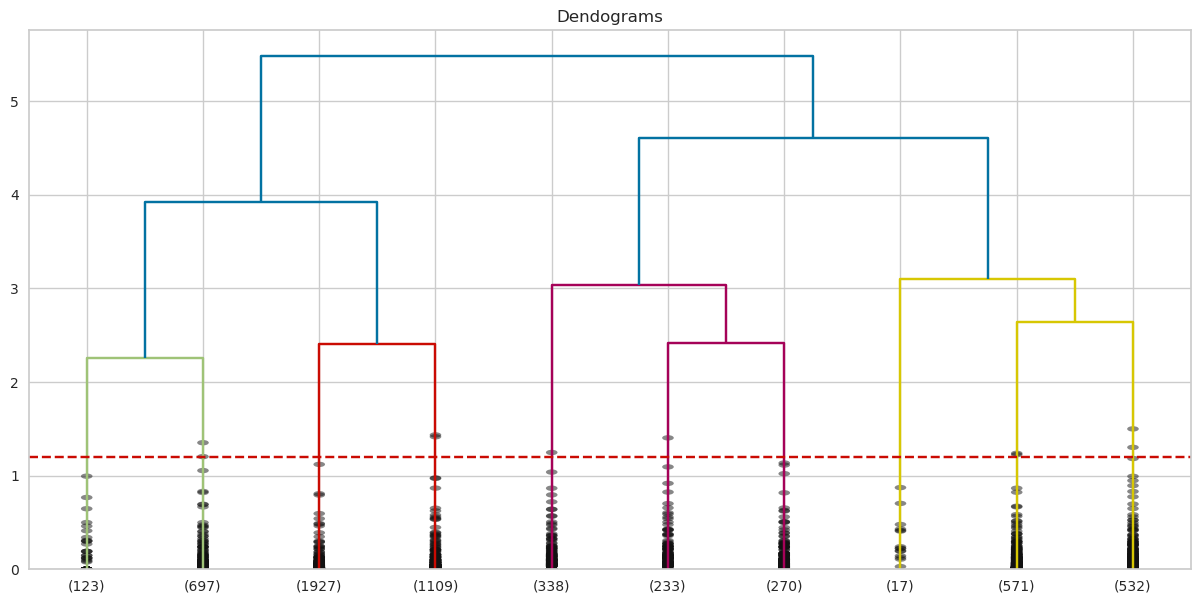

In [26]:
#HİERARCHİCAL Clustering
hc= linkage(scaled_df, "complete")

plt.figure(figsize=(15,7))
plt.title("Dendograms")
dend=dendrogram(hc, 
              truncate_mode="lastp",
              p=10,
              show_contracted=True,
              leaf_font_size=10)
plt.axhline(y=1.2, color="r", linestyle="--")
plt.show()

In [27]:
hc = AgglomerativeClustering(n_clusters=6)
segments=hc.fit_predict(scaled_df)
rfm["HİERARCHİCAL_SEG"]= segments+1
rfm.groupby("HİERARCHİCAL_SEG").agg({"RECENCY": ["median","mean","count"],
                                    "FREQUENCY":["median","mean","count"],
                                    "MONETARY": ["median","mean","count"]
                                   })

RECENCY              FREQUENCY             MONETARY              
                  median   mean count    median  mean count   median    mean count
HİERARCHİCAL_SEG                                                                  
1                  62.00  87.25  1599      5.00  5.96  1599  1370.46 2030.14  1599
2                   6.00   7.01   502      5.00  5.27   502  1186.91 1720.28   502
3                  16.00  20.52   783     16.00 20.10   783  5421.94 7437.88   783
4                 375.00 358.65  1223      3.00  3.01  1223   655.50  926.03  1223
5                  44.00  54.77   544      1.00  1.27   544   303.36  450.62   544
6                 438.00 463.58  1166      1.00  1.00  1166   192.30  295.09  1166

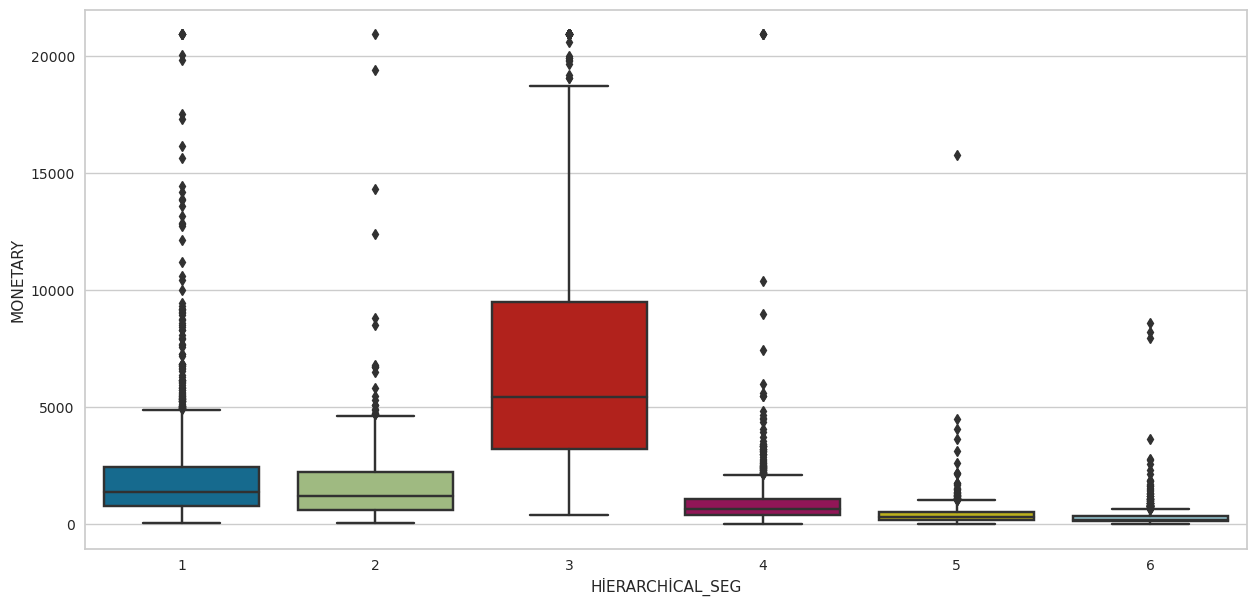

In [28]:
plt.figure(figsize=(15,7))
sns.boxplot(x="HİERARCHİCAL_SEG", y="MONETARY", data=rfm)
plt.show()